# Generating the data
1. Generate the Heterogeneous graph
2. Generate the feature set from the clinical notes.
3. Generate the Labels
4. Generate the k-metapath-based similarity matrices
5. Convert the As to edge-based.
6. Downsize the X to a vector of 32 values.

## 1. Generate the Heterogeneous graph

In [1]:
from  ModelFunctions import *

# Targetted patients:
- We need to identify the sample/set of patients first.
- Patients are identified with C symbol.


In [2]:

import random

num_Diseases = 100 # number of labels...
disease_file = 'sample_one' # depending on your study, this may change...
# ============================================================================
folder_path = '/Users/aryashah/Desktop/MIMIC_resources'
patients = pd.read_csv('/Users/aryashah/Desktop/MIMIC_resources/DIAGNOSES_ICD.csv')
all_patients = patients['SUBJECT_ID'].unique()
sample_of_patients = random.sample(list(all_patients), 1500)
# ============================================================================

patients = sample_of_patients

new_Diagnosis, new_Prescriptions, new_Procedures = load_patients_data(patients, num_Diseases)

CV_edges , VD_edges , VP_edges , VM_edges = get_homogeneous_graphs(new_Diagnosis, new_Prescriptions, new_Procedures)

HG = get_Heterogeneous_graph(CV_edges , VD_edges , VP_edges , VM_edges)

# ============================================================================
# Where do you want to save the resulted data ..
# All the following data should be saved to HGNN_data folder.
# A dedicated folder for the generated data should work perfectly.
saving_path = f'Data/{disease_file}'

for p in ['HGNN_data', 'clinical_items', 'GMLs', 'OHV', 'PSGs', 'SNFs']:
    os.makedirs(f'{saving_path}/{p}', exist_ok=True)

saving_path = f'Data/{disease_file}/HGNN_data'
# ============================================================================

# Save the graph to a GML file
nx.write_gml(HG, f'{saving_path}/the_complete_hetero_graph.gml')
# ============================================================================


Use the patients inside the new DF....
For the given diagnosis, extract the sub dataframe....
Diagnoses frequency =  ['427', '276', '401', '428', '414', '250', '272', '285', '518', '584', 'V45', '530', 'V58', '599', 'E87', '585', '403', 'V29', 'V30', 'V10', '038', 'V05', '998', '305', '995', '785', '780', '765', '410', '041', '997', 'V15', '996', '424', '458', '707', '244', '287', '496', '486', '493', 'E93', 'V12', '790', '070', '571', '348', '770', '511', '507', '412', '311', '327', 'E88', '300', '578', '278', '733', 'V43', '774', '303', '789', '416', '572', '787', 'V50', '482', '197', '425', 'E84', '788', '600', '198', '280', '443', '560', '779', '411', 'V49', '562', '294', '577', '274', '426', '357', 'V44', '434', '286', '715', '440', '799', '345', '296', '275', '682', '008', '438', '724', '441', '433']
General Information:
---------------------------
Number of Patients = 1500
Number of Diagnosis = 100
Number of procedures = 79
Number of Medication = 71
-----------------------------

/Users/aryashah/Downloads/data_generation/ModelFunctions.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_Diagnosis.dropna(subset=['ICD9_CODE'], inplace=True)
/Users/aryashah/Downloads/data_generation/ModelFunctions.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_Procedures.dropna(subset=['ICD9_CODE'], inplace=True)
/Users/aryashah/Downloads/data_generation/ModelFunctions.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-c

In [3]:
all_patients 

array([  109,   112,   113, ..., 97488, 97492, 97497])

## 2. Generate the feature set from the clinical notes.

In [4]:
df_patients, patient_emb_dict, embedding_df = read_embedding()

C_Nodes, V_Nodes, M_Nodes, D_Nodes, P_Nodes, G = get_Nodes(HG)

Nodes = C_Nodes + V_Nodes + M_Nodes + D_Nodes + P_Nodes

int_Patients     = [int(p[2:]) for p in C_Nodes]
patient_list     = [p for p in int_Patients if p in df_patients]  
ignored_patients = [p for p in int_Patients if p not in df_patients] 
print(f'Number of Ignored patients are : {len(ignored_patients)}')

# --------------------------------------------------------------------

emb = mark_all_nodes(Nodes, C_Nodes, V_Nodes, M_Nodes, D_Nodes, P_Nodes)

# --------------------------------------------------------------------
print('Delete the ignored patient from Nodes and emb')
for r in ignored_patients:
    p = f'C_{r}'
    ind = Nodes.index(p)
    Nodes.remove(p)
    emb.pop(p)
# --------------------------------------------------------------------

w = len(proc_string_list(patient_emb_dict[list(patient_emb_dict.keys())[0]]))
# --------------------------------------------------------------------

temp_emb = {}
for v in Nodes:
    if v[0]=='C':
        p = int(v[2:])
        temp = proc_string_list(patient_emb_dict[p]) + emb[v]
    else:
        temp = [0] * w + emb[v]
    temp_emb[v] = temp

x = torch.tensor([temp_emb[v] for v in temp_emb], dtype=torch.float)

torch.save(x, f'{saving_path}/X.pt')
# --------------------------------------------------------------------

with open(f'{saving_path}/Nodes.pkl', 'wb') as file:
    pickle.dump(Nodes, file)
# --------------------------------------------------------------------

nodes_to_delete = [f'C_{i}' for i in ignored_patients]

print(f'Number of nodes before removal: {len(G.nodes())}')

for nd in nodes_to_delete:
    if nd in G.nodes():
        G.remove_node(nd)

print(f'Number of nodes after removal: {len(G.nodes())}')

print('Saving the new graph...')

# Now, G has the ultimate structure. We should save it, right??
nx.write_gml(G, f'{saving_path}/the_complete_hetero_graph2.gml')


Reading the embedding of the entire MIMIC dataset...
number of patients in the embedding file is 46145
	Returning the list of patients and their embedding...
number of patients = 1468
number of visits = 1883
number of Medication = 71
number of Diagnoses = 100
number of Procedures = 79
Number of Ignored patients are : 10
Assingning embedding to the other nodes.
	 The GNN model shall identify the other nodes as well, right?.
	Done --> Assingning embedding to the other nodes.
Delete the ignored patient from Nodes and emb
Number of nodes before removal: 3601
Number of nodes after removal: 3591
Saving the new graph...


## 3. Generate the Labels

number of patients = 1458
number of visits = 1883
number of Medication = 71
number of Diagnoses = 100
number of Procedures = 79
reading the following
1- Patients = 1458
2- Visits = 1883
3- Medication = 71
4- Diagnosis = 100
5- Procedures = 79

Total = 3591, Nodes = 3591
['C_63', 'C_313', 'C_163', 'C_168', 'C_172', 'C_154', 'C_200', 'C_219', 'C_232', 'C_234', 'C_384', 'C_344', 'C_345', 'C_279', 'C_430', 'C_537', 'C_488', 'C_512', 'C_571', 'C_768', 'C_724', 'C_743', 'C_780', 'C_942', 'C_905', 'C_902', 'C_823', 'C_835', 'C_1154', 'C_1158', 'C_1189', 'C_1050', 'C_1108', 'C_1343', 'C_1229', 'C_1239', 'C_1212', 'C_1218', 'C_1299', 'C_1575', 'C_1442', 'C_2658', 'C_1600', 'C_3033', 'C_2768', 'C_2853', 'C_2861', 'C_2948', 'C_2981', 'C_2994', 'C_3010', 'C_3127', 'C_3258', 'C_3415', 'C_3273', 'C_3088', 'C_3383', 'C_3155', 'C_3292', 'C_3429', 'C_3167', 'C_3177', 'C_3304', 'C_3459', 'C_2610', 'C_3357', 'C_3368', 'C_3224', 'C_1884', 'C_2915', 'C_2093', 'C_2094', 'C_2099', 'C_2146', 'C_2161', 'C_1803

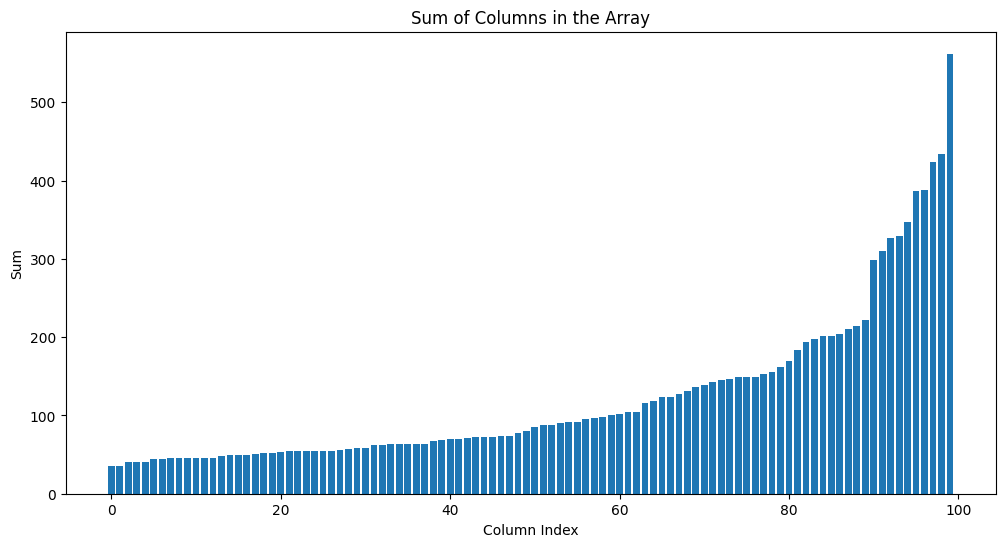

In [5]:
Patients, Visits, Medications, Diagnosis, Procedures, G = get_Nodes(G)

print(f'reading the following\n1- Patients = {len(Patients)}\n2- Visits = {len(Visits)}\n3- Medication = {len(Medications)}\n4- Diagnosis = {len(Diagnosis)}\n5- Procedures = {len(Procedures)}\n')
# ---------------------------------------------------------------

Nodes = Patients + Visits + Medications + Diagnosis  + Procedures
# ---------------------------------------------------------------
print(f'Total = {len(Nodes)}, Nodes = {len(G.nodes())}')


print(Nodes)
# Generating_Y
Diagnosis_index = {d: i for i, d in enumerate(Diagnosis)}

labels = get_label(Nodes, G, Diagnosis_index)
Y = np.array(labels)

print(Y)

Y = remove_one_class_columns(Y, len(Patients))
print(Y.shape)

torch.save(Y, f'{saving_path}/Y.pt')


# Plotting
import matplotlib.pyplot as plt
column_sums = sorted(Y.sum(axis=0))
plt.figure(figsize=(12, 6))  # Set the figure size as needed
plt.bar(range(len(column_sums)), column_sums)# for a bar chart
plt.title('Sum of Columns in the Array')
plt.xlabel('Column Index')
plt.ylabel('Sum')
plt.show()

## 4. Generate the k-metapath-based similarity matrices

In [6]:
C = len(Patients)
V = len(Visits)
Me = len(Medications)
D = len(Diagnosis)
P = len(Procedures)
t = [C, V, Me, D, P]

total = sum([C, V, Me, D, P])
print(f'Number of nodes in G = {total}')
print(f'Number of nodes in Nodes = {len(Nodes)}')



# Check if the directory exists, and create it if it doesn't
Nodes_path = f'{saving_path}/Nodes'
if not os.path.exists(Nodes_path):
    os.makedirs(Nodes_path)

with open(f'{Nodes_path}/patients.pkl', 'wb') as file:
    pickle.dump(Patients, file)

with open(f'{Nodes_path}/visits.pkl', 'wb') as file:
    pickle.dump(Visits, file)

with open(f'{Nodes_path}/medication.pkl', 'wb') as file:
    pickle.dump(Medications, file)

with open(f'{Nodes_path}/diagnosis.pkl', 'wb') as file:
    pickle.dump(Diagnosis, file)

with open(f'{Nodes_path}/procedures.pkl', 'wb') as file:
    pickle.dump(Procedures, file)
    


W_cv = get_adjacency_matrix1(G, Patients, Visits)
W_vm = get_adjacency_matrix1(G, Visits, Medications)
W_vd = get_adjacency_matrix1(G, Visits, Diagnosis)
W_vp = get_adjacency_matrix1(G, Visits, Procedures)  

del Patients
del Visits
del Medications
del Diagnosis
del Procedures



print(type(W_cv))
print([a.shape for a in [W_cv, W_vm, W_vd, W_vp]], total)

# ------ asymmetric similarities
M_CVM = M(W_cv, W_vm)
M_CVP = M(W_cv, W_vp)

M_MVP = M(W_vm.T, W_vp) # MVP

print(W_cv.shape, W_vm.shape)

# Symmetric
# -------Visits--------
M_VDV = M(W_vd, W_vd.T)

M_VMV = M(W_vm, W_vm.T)
M_VPV = M(W_vp, W_vp.T)

# -------Patients--------

M_CVMVC = M(M_CVM, M_CVM.T)
M_CVPVC = M(M_CVP, M_CVP.T)

# -------Medications--------
M_MVM = M(W_vm.T, W_vm)

M_MVPVM = M(M_MVP, M_MVP.T)


# ----------Diagnosis--------------
M_DVD = M(W_vd.T, W_vd)


# -------Procedures----------
M_PVP = M(W_vp.T, W_vp)

# *********************************************************************************************************
print(t, W_cv.shape)
# *********************************************************************************************************

#asym = [W_cv ,  W_vm,    W_vd,     W_vp,]
#dim  = [(0, C) , (C, C+V), (C, C+V+Me), (C, C+V+Me+D)]

#asym = [norm_max(A) for A in asym]
#As2 = [asymmetric_assign_Coo(A, dim[i][0], dim[i][1], sum(t)) for i, A in enumerate(asym)]

# *********************************************************************************************************
del W_cv
del W_vm
del W_vd
del W_vp

#asym3 = [M_CVM,     M_CVP,        M_MVP]
#dim3  = [(0, C+V), (0,C+V+Me+D), (C+V, C+V+Me+D)]

del M_CVM
del M_CVP
del M_MVP

#asym3 = [norm_max(a) for a in asym3]
#As3 = [asymmetric_assign_Coo(A, dim3[i][0], dim3[i][1], sum(t)) for i, A in enumerate(asym3) ]

# M_CVD, (0, C+V+Me), 
# M_MVD, (C+V, C+V+Me), 
# M_DVP, (C+V+Me, C+V+Me+D)

# C --> 0
# V --> C
# M --> C+V
# D --> C+V+Me
# P --> C+V+Me+D

print(t)
print(0, C, C+V, C+V+Me, C+V+Me+D, sum(t))

sym = [M_VDV, M_VMV, M_VPV, M_CVMVC, M_CVPVC, M_MVM, M_MVPVM, M_DVD,  M_PVP    ]
shf = [C    , C    , C    , 0      , 0      , C+V  , C+V    , C+V+Me, C+V+Me+D ]
sym = [norm_max(a) for a in sym]

del M_CVMVC
del M_CVPVC
del M_MVM
del M_MVPVM
del M_DVD
del M_PVP


As = [symmetric_assign2(A, shf[i], sum(t)) for i, A in enumerate(sym)]

#newAS2 = [a.toarray() for a in As2]
#newAS3 = [a.toarray() for a in As3]

#for a in As:
    #print(a.shape)

#for a in newAS2:
    #print(a.shape)

#for a in newAS3:
    #print(a.shape)

#As.extend(newAS2)
#As.extend(newAS3)


# The fusing section

# Here, we divide each A by its max
# and consider the average of A_i.

normalized_As = [Ai / Ai.max() for Ai in As]

A_final = sum(normalized_As) / len(normalized_As)

# Check if the directory exists, and create it if it doesn't
As_path = f'{saving_path}/A'
if not os.path.exists(As_path):
    os.makedirs(As_path)

# Convert each numpy array to a CSR sparse matrix and save it
for i, arr in enumerate(As):
    sparse_matrix = sparse.csr_matrix(arr)
    sparse.save_npz(f"{As_path}/sparse_matrix_{i}.npz", sparse_matrix)
    print(f'{i}\'th matrix saved!')

sparse_matrix = sparse.csr_matrix(A_final)
sparse.save_npz(f"{As_path}/A_final.npz", sparse_matrix)

Number of nodes in G = 3591
Number of nodes in Nodes = 3591
<class 'scipy.sparse._arrays.csr_array'>
[(1458, 1883), (1883, 71), (1883, 100), (1883, 79)] 3591
multiplying (1458, 1883) * (1883, 71)...
Done multiplication...
multiplying (1458, 1883) * (1883, 79)...
Done multiplication...
multiplying (71, 1883) * (1883, 79)...
Done multiplication...
(1458, 1883) (1883, 71)
multiplying (1883, 100) * (100, 1883)...
Done multiplication...
multiplying (1883, 71) * (71, 1883)...
Done multiplication...
multiplying (1883, 79) * (79, 1883)...
Done multiplication...
multiplying (1458, 71) * (71, 1458)...
Done multiplication...
multiplying (1458, 79) * (79, 1458)...
Done multiplication...
multiplying (71, 1883) * (1883, 71)...
Done multiplication...
multiplying (71, 79) * (79, 71)...
Done multiplication...
multiplying (100, 1883) * (1883, 100)...
Done multiplication...
multiplying (79, 1883) * (1883, 79)...
Done multiplication...
[1458, 1883, 71, 100, 79] (1458, 1883)
[1458, 1883, 71, 100, 79]
0 145

## 5. Convert the As to edge-based.

In [7]:
# Check if the directory exists, and create it if it doesn't
Nodes_path = f'{saving_path}/edges'
if not os.path.exists(Nodes_path):
    os.makedirs(Nodes_path)

D = [get_edges_dict(f'{saving_path}/A/sparse_matrix_{i}.npz') for i in range(16)]
sorted_list_of_dicts = sorted(D, key=lambda x: len(x), reverse=True)

unique_edges = set()

for e in sorted_list_of_dicts:
    unique_edges.update(e.keys())

    
with open(f'{saving_path}/edges/edge_list.pkl', 'wb') as file:
    pickle.dump(unique_edges, file)

print('done saving [unique edges]: ', len(unique_edges))

for i, d in enumerate(D):
    print(f'Working on {i}th file...')
    results = []
    for e in unique_edges:
        if e in d:
            results.append(d[e])
        else:
            results.append(0)
    print(f'\tdone...')
    print('\tSaving...')

    with open(f'{saving_path}/edges/edge_weight{i}.pkl', 'wb') as file:
        pickle.dump(results, file)

    print(f'\tDone saving edge_weight{i}...')
    


done saving [unique edges]:  1565004
Working on 0th file...
	done...
	Saving...
	Done saving edge_weight0...
Working on 1th file...
	done...
	Saving...
	Done saving edge_weight1...
Working on 2th file...
	done...
	Saving...
	Done saving edge_weight2...
Working on 3th file...
	done...
	Saving...
	Done saving edge_weight3...
Working on 4th file...
	done...
	Saving...
	Done saving edge_weight4...
Working on 5th file...
	done...
	Saving...
	Done saving edge_weight5...
Working on 6th file...
	done...
	Saving...
	Done saving edge_weight6...
Working on 7th file...
	done...
	Saving...
	Done saving edge_weight7...
Working on 8th file...
	done...
	Saving...
	Done saving edge_weight8...
Working on 9th file...
	done...
	Saving...
	Done saving edge_weight9...
Working on 10th file...
	done...
	Saving...
	Done saving edge_weight10...
Working on 11th file...
	done...
	Saving...
	Done saving edge_weight11...
Working on 12th file...
	done...
	Saving...
	Done saving edge_weight12...
Working on 13th file.

## 6. Downsize the X to a vector of 32 values.

In [8]:
x = torch.load(f'{saving_path}/X.pt')
# reducing the size of the embedding, using PCA !

from sklearn.decomposition import PCA
n_samples, n_features = x.shape

# Set n_components to be less than or equal to the min(n_samples, n_features)
n_components = min(n_samples, n_features, 32)  # As an example, ensuring it's within bounds

# Initialize and apply PCA
pca = PCA(n_components=n_components)
new_x = pca.fit_transform(x)

torch.save(new_x, f'{saving_path}/X_32.pt')

/var/folders/8g/3hbzmhdj28zbn6lxr6vqn4n00000gn/T/ipykernel_91228/2795935298.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x = torch.load(f'{saving_path}/X.pt')
